In [11]:
%load_ext autoreload
%autoreload 2

import pathlib

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import img_as_ubyte
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchsummary import summary

from core.layers import *
from core.image import *
from core.utils import *
torch.set_printoptions(sci_mode=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
with open("data/coco.names") as f:
    content = f.read().strip()
    coco_labels = content.split("\n")
    colors = get_colors(len(coco_labels))

In [4]:
from core.models import Darknet

# net_params, layer_infos = parse_darknet_cfg("cfg/yolov3-tiny.cfg")
net_params, layer_infos = parse_darknet_cfg("cfg/yolov3.cfg")

net = Darknet(net_params, layer_infos)
input_dim = net_params["height"], net_params["width"]
# net.load_weights("weights/yolov3-tiny.weights")
net.load_weights("weights/yolov3.weights")

Total weights in file: 62001757
Total weights loaded: 62001757


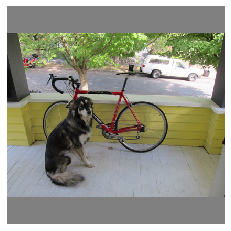

In [5]:
img = Image.open("data/dog.jpg")

# Pad & resize
resized_img = letterbox_image(img, input_dim)
img = np.array(img)

plt.axis("off")
plt.imshow(resized_img)

net_input = torch.from_numpy(np.transpose(resized_img, [2, 0, 1])).type(torch.float32)
net_input /= 255.
net_input = net_input.unsqueeze(0)

with torch.no_grad():
    net.eval()
    net_output = net(net_input)

In [15]:
type(np.ones(1))

numpy.ndarray

In [22]:
rects, labels, scores = non_max_surpression(net_output[0], conf_threshold=0.25, iou_threshold=0.4)
rects = scale_rects(rects, img.shape[:2], input_dim)
labels = [coco_labels[i] for i in labels]
draw_predictions(img, rects, labels, scores)